In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal
import numpy as np
import cv2

In [ ]:
a_tipo_F=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_F.jpeg")
a_tipo_Q=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_Q.jpeg")
a_tipo_S=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_S.jpeg")
a_tipo_V=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_V.jpeg")
normal =("/content/drive/MyDrive/arritmias_final/Normal.jpeg")
arritmia_F_V = "/content/vector_001(1).bmp"
arritmia_F_V2 = "/content/WhatsApp Image 2023-05-06 at 20.10.31.jpeg"
arritmia_F_V3 = "/content/vector_002.bmp"
arritmia_F_V3 = "/content/vector_003.bmp"
arritmia_F_V4 = "/content/vector_004.bmp"

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy.signal import medfilt, find_peaks

def load_image(image_path):
    # Abre la imagen desde la ruta proporcionada y devuelve el objeto de imagen
    img = Image.open(image_path)
    return img

def to_grayscale(img):
    # Convierte la imagen a escala de grises y devuelve la imagen en escala de grises
    return img.convert('L')

def apply_threshold(img_grayscale, threshold_value=150):
    # Aplica un umbral a la imagen en escala de grises y devuelve la imagen binarizada
    return img_grayscale.point(lambda x: 0 if x < threshold_value else 255, '1')

def invert_image(img_binary):
    # Invierte los colores de la imagen binarizada y devuelve la imagen invertida
    img_array = np.array(img_binary).astype(np.uint8)
    return Image.fromarray(255 - img_array)

def crop_bottom_section(image, y_factor=0.715, height_factor=0.2):
    # Normaliza la imagen y recorta la sección inferior en función de los factores proporcionados
    img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    height, width = image.shape[:2]
    x = 0
    y = int(height * y_factor)
    w = width
    h = int(height * height_factor)
    return img_norm[y:y+h, x:x+w]

def binarize_image(image, threshold=128):
    # Binariza la imagen utilizando el valor de umbral proporcionado
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def ecg_vector_from_binary(binary_image):
    # Extrae el vector ECG de la imagen binaria
    white_points = np.where(binary_image == 255)
    x_coords = white_points[1]
    y_coords = white_points[0]
    sorted_indices = np.argsort(x_coords)
    y_values = y_coords[sorted_indices]
    height, _ = binary_image.shape
    y_values_inverted = height - y_values
    ecg_vector = y_values_inverted.astype(np.float64)
    return ecg_vector

def smooth_ecg_vector(ecg_vector, window_size=7):
    # Suaviza el vector ECG utilizando un filtro de mediana con un tamaño de ventana específico
    return medfilt(ecg_vector, window_size)

def detect_peaks(ecg_vector, prominence=20, min_distance=50):
    # Detecta picos en el vector ECG utilizando la prominencia y la distancia mínima proporcionadas
    peaks, _ = find_peaks(ecg_vector, prominence=prominence, distance=min_distance)
    return peaks

def plot_ecg(ecg_vector, peaks=None):
    # Grafica el vector ECG y, si se proporcionan, los picos detectados
    plt.figure(figsize=(10, 6))
    plt.plot(ecg_vector)
    if peaks is not None:
        plt.plot(peaks, ecg_vector[peaks], "x")
    plt.ylabel('ECG Amplitude')
    plt.xlabel('Time')
    plt.show()


#FUNCIÓN PRINCIPAL
def process_image(image_path):
    img = load_image(image_path)
    img_grayscale = to_grayscale(img)
    img_binary = apply_threshold(img_grayscale)
    img_inverted = invert_image(img_binary)
    image = np.array(img_inverted).astype(np.uint8)
    bottom_section = crop_bottom_section(image)
    binary_image = binarize_image(bottom_section)
    ecg_vector = ecg_vector_from_binary(binary_image)
    smoothed_ecg_vector = smooth_ecg_vector(ecg_vector)
    peaks = detect_peaks(smoothed_ecg_vector)
    plot_ecg(smoothed_ecg_vector, peaks)
    return smoothed_ecg_vector


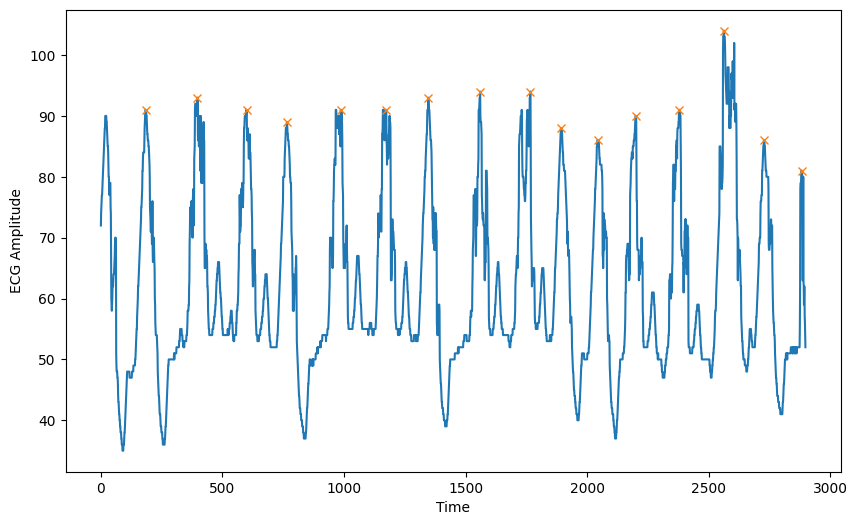

In [ ]:
image_path = a_tipo_F

#Vector preprocesado preparado para el 2º procesado
model_vectro_preprocess = process_image(image_path)

###De aqui en adelante transformamos el vector para el modelo

In [ ]:
!pip install wfdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import argrelextrema

In [ ]:
def record_a_vector(record):
    vector = np.squeeze(record.p_signal) # Quita las dimensiones innecesarias del array (de 2D a 1D)
    return vector

def grafica_vector(vector):
    plt.figure(figsize=(15, 5))
    plt.plot(vector)
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.title("Vector ECG")
    plt.grid(True)
    plt.show()

def remuestreo_inicial(vector_original, fs_original, fs_nueva):
    # Calcular la cantidad de muestras en el nuevo vector
    n_muestras_original = len(vector_original)
    n_muestras_nueva = int(n_muestras_original * fs_nueva / fs_original)
    # Remuestrear el vector
    vector_remuestreado = resample(vector_original, n_muestras_nueva)
    return vector_remuestreado

def normalizar_vector(vector):
    minimo = np.min(vector)
    maximo = np.max(vector)
    vector_normalizado = (vector - minimo) / (maximo - minimo)
    return vector_normalizado

def derivar_vector(vector):
    derivada = np.gradient(vector)
    return derivada

def eliminar_valores_negativos(vector):
    vector_sin_negativos = np.clip(vector, 0, None) # Los valores menores de 0 se reemplazan con 0
    return vector_sin_negativos

def media_latidos(indices):
    # Calcular las diferencias entre los índices consecutivos de los máximos
    diferencias = np.diff(indices)
    # Calcular la media de las diferencias
    media_diferencias = np.mean(diferencias)
    return media_diferencias


def comparar(a, b):
    return a > b

def encontrar_maximos(vector, umbral, distancia_minima):
    # Encontrar los índices de los máximos locales que superan el umbral
    indices_maximos = argrelextrema(vector, comparar, order=distancia_minima)
    # Filtrar los máximos locales para asegurar que superen el umbral
    indices_filtrados = [indice for indice in indices_maximos[0] if vector[indice] > umbral]
    return np.array(indices_filtrados)

def extraer_segmentos_10seg(vector, indices_maximos, media):
    segmentos = []
    ventana = int(media / 2)
    
    for indice in indices_maximos:
        inicio = indice - ventana
        fin = indice + ventana
        
        # Verificar si hay suficientes muestras a la izquierda y a la derecha del índice
        if inicio >= 0 and fin < len(vector):
            segmento = vector[inicio:fin]
            segmentos.append(segmento)
    
    return segmentos

def ajustar_longitud(segmentos, longitud_objetivo):
    segmentos_ajustados = []
    
    for segmento in segmentos:
        if len(segmento) < longitud_objetivo:
            # Rellenar con ceros si el segmento es más corto que la longitud objetivo
            segmento_ajustado = np.pad(segmento, (0, longitud_objetivo - len(segmento)), 'constant')
        else:
            # Si el segmento es más largo que la longitud objetivo, tomar los primeros 187 valores
            segmento_ajustado = segmento[:longitud_objetivo]
        
        segmentos_ajustados.append(segmento_ajustado)
            
    return segmentos_ajustados

def grafica_normalizado_latidos(vector_norm, indices):
    plt.figure(figsize=(15, 5))
    # Graficar el vector normalizado
    plt.plot(vector_norm)

    # Graficar los máximos locales encontrados
    plt.plot(indices, vector_norm[indices], 'ro')

    # Configurar la gráfica
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title('Vector normalizado y máximos locales')

    # Mostrar la gráfica
    plt.show()


def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector


def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector


def proceso_segmentacion(vector, fs, umbral=0.3, distancia_minima=20, grafica=0):
    if (grafica == 1):
        print("Gráfica del vector original recibido")
        grafica_vector(vector)
    
    #ajustamos la frecuencia de muestreo
    vector_125 = remuestreo_inicial(vector, fs, 125)
    
    if (grafica == 2):
        print("Gráfica del vector ajustado a una frecuencia de 125Hz")
        grafica_vector(vector_125)
    
    #normaliza los 10 segundos
    vector_norm_orig = normalizar_vector(vector_125)
    
    if (grafica == 3):
        print("Gráfica del vector normalizado")
        grafica_vector(vector_norm_orig)
    
    #deriva el vector
    vector_der = derivar_vector(vector_125)
     
    #elimina valores negativos
    vector_sin_ceros = eliminar_valores_negativos(vector_der)    
    #normaliza el vector
    vector_norm = normalizar_vector(vector_sin_ceros)    
    if (grafica == 4):
        print("Gráfica del vector después de derivar, valores >0, normalizar")
        grafica_vector(vector_norm)    
    #umbral = 0.3  # Cambia este valor según el umbral deseado
    #distancia_minima = 10  # Cambia este valor según la distancia mínima deseada entre máximos
    indices_maximos = encontrar_maximos(vector_norm, umbral, distancia_minima)    
    #calcula la media entre latidos
    media = media_latidos(indices_maximos)    
    #extrae segmentos en los 10 segundos
    segmentos_extraidos = extraer_segmentos_10seg(vector_norm_orig, indices_maximos, media)    
    if (grafica == 5):
        print("Gráfica de latidos con vector derivado")
        grafica_normalizado_latidos(vector_norm_orig, indices_maximos)    
    #ajusta longitud de los segmentos
    segmentos_ajustados = ajustar_longitud(segmentos_extraidos, 187)
    
    #genera el dataframe de salida para el modelo
    df_segmentos = pd.DataFrame(segmentos_ajustados)
    

    return df_segmentos
    

In [ ]:
df_signal = proceso_segmentacion(model_vectro_preprocess, fs=360)

In [ ]:
modelo = load_model('/content/drive/MyDrive/saved_models/clasificador_ver5.h5')


In [ ]:
#carga el modelo y evalua "latidos"
def evalua(latidos):
    y_pred = modelo.predict(latidos)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(y_pred_classes)

#Carga el modelo y resume lo predicho    
def evalua_y_resumen(latidos):
    y_pred = modelo.predict(latidos)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    clases = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
    conteo_clases = {key: 0 for key in clases.values()}
    
    for resultado in y_pred_classes:
        tipo_latido = clases[resultado]
        conteo_clases[tipo_latido] += 1
    
    return conteo_clases





In [ ]:
evalua_y_resumen(df_signal)

1/1 [==============================] - 0s 377ms/step


{'N': 1, 'S': 4, 'V': 4, 'F': 0, 'Q': 0}